In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import zipfile
import os
import shutil
import h3
from shapely.geometry import Polygon
import osmnx as ox
from shapely.geometry import Point

# Load, concat and clean census for the metropolitan area

In [179]:
censo_cdmx_manzanas = pd.read_csv('./data/censos/2020/agebs_cdmx.csv')
censo_edomex_manzanas = pd.read_csv('./data/censos/2020/agebs_edomex.csv')
censo_hidalgo_manzanas = pd.read_csv('./data/censos/2020/agebs_hidalgo.csv')

In [180]:
def clean_census_columns(df):

    skip_cols = [
    "ENTIDAD",
    "NOM_ENT",
    "MUN",
    "NOM_MUN",
    "LOC",
    "NOM_LOC",
    "AGEB",
    "MZA"
]
    
    for col in df.columns:
        if col not in skip_cols:
            # Replace "*" with NaN
            df[col] = df[col].replace("*", np.nan)

            # Convert to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [181]:
censo_cdmx_manzanas = clean_census_columns(censo_cdmx_manzanas)
censo_cdmx_manzanas = censo_cdmx_manzanas[~censo_cdmx_manzanas["NOM_LOC"].isin(['Total de la entidad', 'Total del municipio', 'Total de la localidad urbana', 'Total AGEB urbana'])]
censo_edomex_manzanas = clean_census_columns(censo_edomex_manzanas)
censo_edomex_manzanas = censo_edomex_manzanas[~censo_edomex_manzanas["NOM_LOC"].isin(['Total de la entidad', 'Total del municipio', 'Total de la localidad urbana', 'Total AGEB urbana'])]
censo_hidalgo_manzanas = clean_census_columns(censo_hidalgo_manzanas)
censo_hidalgo_manzanas = censo_hidalgo_manzanas[~censo_hidalgo_manzanas["NOM_LOC"].isin(['Total de la entidad', 'Total del municipio', 'Total de la localidad urbana', 'Total AGEB urbana'])]

In [182]:
censo_2020_manzanas = pd.concat([censo_cdmx_manzanas, censo_edomex_manzanas, censo_hidalgo_manzanas], ignore_index=True)
censo_2020_manzanas = censo_2020_manzanas.reset_index(drop=True)
censo_2020_manzanas["ENTIDAD"] = censo_2020_manzanas["ENTIDAD"].apply(lambda x: str(x).zfill(2))
censo_2020_manzanas["MUN"] = censo_2020_manzanas["MUN"].apply(lambda x: str(x).zfill(3))
censo_2020_manzanas["LOC"] = censo_2020_manzanas["LOC"].apply(lambda x: str(x).zfill(4))
censo_2020_manzanas["MZA"] = censo_2020_manzanas["MZA"].apply(lambda x: str(x).zfill(3))
censo_2020_manzanas

ENTIDAD           NOM_ENT  MUN       NOM_MUN   LOC       NOM_LOC  AGEB  \
0           09  Ciudad de México  002  Azcapotzalco  0001  Azcapotzalco  0010   
1           09  Ciudad de México  002  Azcapotzalco  0001  Azcapotzalco  0010   
2           09  Ciudad de México  002  Azcapotzalco  0001  Azcapotzalco  0010   
3           09  Ciudad de México  002  Azcapotzalco  0001  Azcapotzalco  0010   
4           09  Ciudad de México  002  Azcapotzalco  0001  Azcapotzalco  0010   
...        ...               ...  ...           ...   ...           ...   ...   
243652      13           Hidalgo  084       Zimapán  0001       Zimapán  0309   
243653      13           Hidalgo  084       Zimapán  0001       Zimapán  0313   
243654      13           Hidalgo  084       Zimapán  0001       Zimapán  0313   
243655      13           Hidalgo  084       Zimapán  0001       Zimapán  0313   
243656      13           Hidalgo  084       Zimapán  0001       Zimapán  0313   

        MZA  POBTOT  POBFEM  ...  VPH_TELEF  VPH_CEL  VPH_INTER  VPH_STVP  \
0       001     159    86.0  ...       45.0     42.0       39.0      18.0   
1       002     145    80.0  ...       37.0     38.0       32.0      14.0   
2       003     124    64.0  ...       29.0     28.0       25.0      11.0   
3       004     158    83.0  ...       37.0     38.0       34.0      14.0   
4       005     154    86.0  ...       42.0     42.0       38.0      12.0   
...     ...     ...     ...  ...        ...      ...        ...       ...   
243652  005       3     NaN  ...        NaN      NaN        NaN       NaN   
243653  001     102    58.0  ...        NaN     24.0        9.0      10.0   
243654  002      68    32.0  ...        NaN     18.0        5.0       8.0   
243655  003      72    41.0  ...        0.0     21.0        5.0      14.0   
243656  004     104    59.0  ...        NaN     24.0        7.0       7.0   

        VPH_SPMVPI  VPH_CVJ  VPH_SINRTV  VPH_SINLTC  VPH_SINCINT  VPH_SINTIC  
0             13.0      6.0         NaN         0.0          9.0         0.0  
1             12.0      5.0         0.0         0.0          9.0         0.0  
2             15.0      7.0         0.0         NaN          6.0         0.0  
3              4.0      7.0         0.0         0.0          7.0         0.0  
4              5.0      6.0         0.0         0.0          7.0         0.0  
...            ...      ...         ...         ...          ...         ...  
243652         NaN      NaN         NaN         NaN          NaN         NaN  
243653         NaN      0.0         NaN         NaN         13.0         NaN  
243654         NaN      NaN         0.0         NaN          8.0         0.0  
243655         0.0      0.0         4.0         0.0         13.0         0.0  
243656         NaN      NaN         NaN         0.0         13.0         0.0  

[243657 rows x 230 columns]

In [183]:
del censo_cdmx_manzanas
del censo_edomex_manzanas
del censo_hidalgo_manzanas

# Load and concat the geographic data

In [184]:
gdf_cdmx_manzanas = gpd.read_file('./data/marco_geoestadistico/09_ciudaddemexico/conjunto_de_datos/09m.shp')

gdf_cdmx_manzanas = gdf_cdmx_manzanas[['CVEGEO','CVE_ENT', 'CVE_MUN',  'CVE_AGEB', 'CVE_MZA','AMBITO','geometry']]

In [185]:
gdf_edomex_manzanas = gpd.read_file('./data/marco_geoestadistico/15_mexico/conjunto_de_datos/15m.shp')
gdf_edomex_manzanas = gdf_edomex_manzanas[['CVEGEO','CVE_ENT', 'CVE_MUN',  'CVE_AGEB', 'CVE_MZA','AMBITO','geometry']]

In [186]:
gdf_hidalgo_manzanas = gpd.read_file('./data/marco_geoestadistico/13_hidalgo/conjunto_de_datos/13m.shp')
gdf_hidalgo_manzanas = gdf_hidalgo_manzanas[['CVEGEO','CVE_ENT', 'CVE_MUN',  'CVE_AGEB', 'CVE_MZA','AMBITO','geometry']]

In [187]:
gdf_marco_geoestadistico = gpd.GeoDataFrame(pd.concat([gdf_cdmx_manzanas, gdf_edomex_manzanas, gdf_hidalgo_manzanas], ignore_index=True), geometry='geometry', crs=gdf_cdmx_manzanas.crs) 
gdf_marco_geoestadistico = gdf_marco_geoestadistico.reset_index(drop=True)

In [188]:
del gdf_cdmx_manzanas
del gdf_edomex_manzanas
del gdf_hidalgo_manzanas

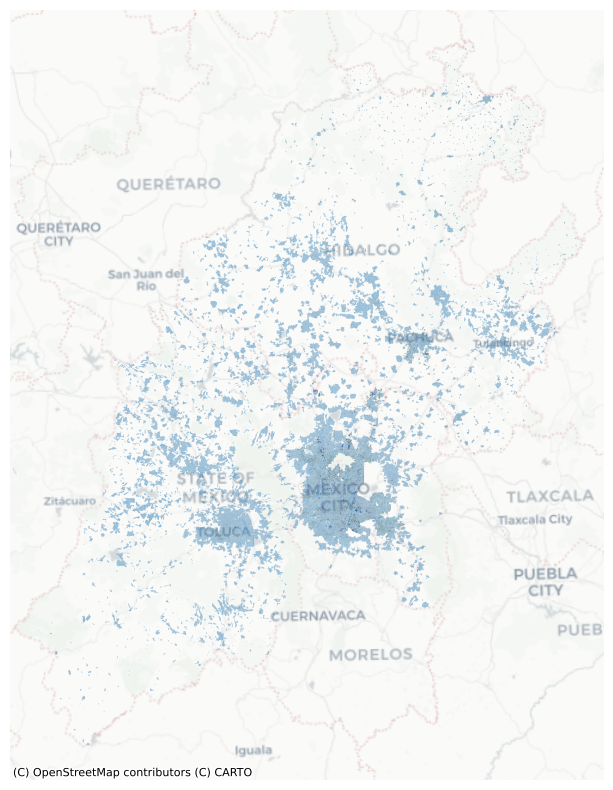

In [189]:
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
gdf_marco_geoestadistico.plot(ax=ax, alpha=0.5, edgecolor='white', linewidth=0.02)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf_marco_geoestadistico.crs)

# Unite census data with geographic data

In [190]:
gdf_marco_geoestadistico

CVEGEO CVE_ENT CVE_MUN CVE_AGEB CVE_MZA  AMBITO  \
0       0901000010898031      09     010     0898     031  Urbana   
1       0901000012269024      09     010     2269     024  Urbana   
2       0901000011472068      09     010     1472     068  Urbana   
3       0901000011824024      09     010     1824     024  Urbana   
4       0901000012377004      09     010     2377     004  Urbana   
...                  ...     ...     ...      ...     ...     ...   
304262  1301900100014031      13     019     0014     031   Rural   
304263  1301900140014012      13     019     0014     012   Rural   
304264  1301900140014010      13     019     0014     010   Rural   
304265  1301900010048001      13     019     0048     001  Urbana   
304266  1301900010048003      13     019     0048     003  Urbana   

                                                 geometry  
0       POLYGON ((2790204.135 820779.247, 2790125.593 ...  
1       POLYGON ((2791387.916 821465.156, 2791376.215 ...  
2       POLYGON ((2788494.355 822775.106, 2788478.422 ...  
3       POLYGON ((2790870.494 819456.298, 2790862.256 ...  
4       POLYGON ((2792111.138 821977.886, 2792115.437 ...  
...                                                   ...  
304262  POLYGON ((2793240.509 934364.95, 2793275.053 9...  
304263  POLYGON ((2789469.78 932957.586, 2789488.009 9...  
304264  POLYGON ((2788949.719 933098.982, 2788951.915 ...  
304265  POLYGON ((2787951.39 928584.223, 2788065.691 9...  
304266  POLYGON ((2787661.838 928320.402, 2787659.94 9...  

[304267 rows x 7 columns]

In [191]:
censo_2020_manzanas

ENTIDAD           NOM_ENT  MUN       NOM_MUN   LOC       NOM_LOC  AGEB  \
0           09  Ciudad de México  002  Azcapotzalco  0001  Azcapotzalco  0010   
1           09  Ciudad de México  002  Azcapotzalco  0001  Azcapotzalco  0010   
2           09  Ciudad de México  002  Azcapotzalco  0001  Azcapotzalco  0010   
3           09  Ciudad de México  002  Azcapotzalco  0001  Azcapotzalco  0010   
4           09  Ciudad de México  002  Azcapotzalco  0001  Azcapotzalco  0010   
...        ...               ...  ...           ...   ...           ...   ...   
243652      13           Hidalgo  084       Zimapán  0001       Zimapán  0309   
243653      13           Hidalgo  084       Zimapán  0001       Zimapán  0313   
243654      13           Hidalgo  084       Zimapán  0001       Zimapán  0313   
243655      13           Hidalgo  084       Zimapán  0001       Zimapán  0313   
243656      13           Hidalgo  084       Zimapán  0001       Zimapán  0313   

        MZA  POBTOT  POBFEM  ...  VPH_TELEF  VPH_CEL  VPH_INTER  VPH_STVP  \
0       001     159    86.0  ...       45.0     42.0       39.0      18.0   
1       002     145    80.0  ...       37.0     38.0       32.0      14.0   
2       003     124    64.0  ...       29.0     28.0       25.0      11.0   
3       004     158    83.0  ...       37.0     38.0       34.0      14.0   
4       005     154    86.0  ...       42.0     42.0       38.0      12.0   
...     ...     ...     ...  ...        ...      ...        ...       ...   
243652  005       3     NaN  ...        NaN      NaN        NaN       NaN   
243653  001     102    58.0  ...        NaN     24.0        9.0      10.0   
243654  002      68    32.0  ...        NaN     18.0        5.0       8.0   
243655  003      72    41.0  ...        0.0     21.0        5.0      14.0   
243656  004     104    59.0  ...        NaN     24.0        7.0       7.0   

        VPH_SPMVPI  VPH_CVJ  VPH_SINRTV  VPH_SINLTC  VPH_SINCINT  VPH_SINTIC  
0             13.0      6.0         NaN         0.0          9.0         0.0  
1             12.0      5.0         0.0         0.0          9.0         0.0  
2             15.0      7.0         0.0         NaN          6.0         0.0  
3              4.0      7.0         0.0         0.0          7.0         0.0  
4              5.0      6.0         0.0         0.0          7.0         0.0  
...            ...      ...         ...         ...          ...         ...  
243652         NaN      NaN         NaN         NaN          NaN         NaN  
243653         NaN      0.0         NaN         NaN         13.0         NaN  
243654         NaN      NaN         0.0         NaN          8.0         0.0  
243655         0.0      0.0         4.0         0.0         13.0         0.0  
243656         NaN      NaN         NaN         0.0         13.0         0.0  

[243657 rows x 230 columns]

In [192]:
censo_2020_manzanas.rename(columns={"ENTIDAD": "CVE_ENT", "MUN": "CVE_MUN", "AGEB": "CVE_AGEB", "MZA": "CVE_MZA"}, inplace=True)

In [193]:
gdf_census_data = gdf_marco_geoestadistico.merge(censo_2020_manzanas, left_on=['CVE_ENT', 'CVE_MUN', 'CVE_AGEB', 'CVE_MZA'], right_on=['CVE_ENT', 'CVE_MUN', 'CVE_AGEB', 'CVE_MZA'], how='left').drop(columns=['LOC', "NOM_LOC"])


In [194]:
columns_reordered = [
'CVEGEO',
'CVE_ENT',
'NOM_ENT',
'CVE_MUN',
'NOM_MUN',
'CVE_AGEB',
'CVE_MZA',
'AMBITO',
'POBTOT',
'POBFEM',
'POBMAS',
'P_0A2',
'P_0A2_F',
'P_0A2_M',
'P_3YMAS',
'P_3YMAS_F',
'P_3YMAS_M',
'P_5YMAS',
'P_5YMAS_F',
'P_5YMAS_M',
'P_12YMAS',
'P_12YMAS_F',
'P_12YMAS_M',
'P_15YMAS',
'P_15YMAS_F',
'P_15YMAS_M',
'P_18YMAS',
'P_18YMAS_F',
'P_18YMAS_M',
'P_3A5',
'P_3A5_F',
'P_3A5_M',
'P_6A11',
'P_6A11_F',
'P_6A11_M',
'P_8A14',
'P_8A14_F',
'P_8A14_M',
'P_12A14',
'P_12A14_F',
'P_12A14_M',
'P_15A17',
'P_15A17_F',
'P_15A17_M',
'P_18A24',
'P_18A24_F',
'P_18A24_M',
'P_15A49_F',
'P_60YMAS',
'P_60YMAS_F',
'P_60YMAS_M',
'REL_H_M',
'POB0_14',
'POB15_64',
'POB65_MAS',
'PROM_HNV',
'PNACENT',
'PNACENT_F',
'PNACENT_M',
'PNACOE',
'PNACOE_F',
'PNACOE_M',
'PRES2015',
'PRES2015_F',
'PRES2015_M',
'PRESOE15',
'PRESOE15_F',
'PRESOE15_M',
'P3YM_HLI',
'P3YM_HLI_F',
'P3YM_HLI_M',
'P3HLINHE',
'P3HLINHE_F',
'P3HLINHE_M',
'P3HLI_HE',
'P3HLI_HE_F',
'P3HLI_HE_M',
'P5_HLI',
'P5_HLI_NHE',
'P5_HLI_HE',
'PHOG_IND',
'POB_AFRO',
'POB_AFRO_F',
'POB_AFRO_M',
'PCON_DISC',
'PCDISC_MOT',
'PCDISC_VIS',
'PCDISC_LENG',
'PCDISC_AUD',
'PCDISC_MOT2',
'PCDISC_MEN',
'PCON_LIMI',
'PCLIM_CSB',
'PCLIM_VIS',
'PCLIM_HACO',
'PCLIM_OAUD',
'PCLIM_MOT2',
'PCLIM_RE_CO',
'PCLIM_PMEN',
'PSIND_LIM',
'P3A5_NOA',
'P3A5_NOA_F',
'P3A5_NOA_M',
'P6A11_NOA',
'P6A11_NOAF',
'P6A11_NOAM',
'P12A14NOA',
'P12A14NOAF',
'P12A14NOAM',
'P15A17A',
'P15A17A_F',
'P15A17A_M',
'P18A24A',
'P18A24A_F',
'P18A24A_M',
'P8A14AN',
'P8A14AN_F',
'P8A14AN_M',
'P15YM_AN',
'P15YM_AN_F',
'P15YM_AN_M',
'P15YM_SE',
'P15YM_SE_F',
'P15YM_SE_M',
'P15PRI_IN',
'P15PRI_INF',
'P15PRI_INM',
'P15PRI_CO',
'P15PRI_COF',
'P15PRI_COM',
'P15SEC_IN',
'P15SEC_INF',
'P15SEC_INM',
'P15SEC_CO',
'P15SEC_COF',
'P15SEC_COM',
'P18YM_PB',
'P18YM_PB_F',
'P18YM_PB_M',
'GRAPROES',
'GRAPROES_F',
'GRAPROES_M',
'PEA',
'PEA_F',
'PEA_M',
'PE_INAC',
'PE_INAC_F',
'PE_INAC_M',
'POCUPADA',
'POCUPADA_F',
'POCUPADA_M',
'PDESOCUP',
'PDESOCUP_F',
'PDESOCUP_M',
'PSINDER',
'PDER_SS',
'PDER_IMSS',
'PDER_ISTE',
'PDER_ISTEE',
'PAFIL_PDOM',
'PDER_SEGP',
'PDER_IMSSB',
'PAFIL_IPRIV',
'PAFIL_OTRAI',
'P12YM_SOLT',
'P12YM_CASA',
'P12YM_SEPA',
'PCATOLICA',
'PRO_CRIEVA',
'POTRAS_REL',
'PSIN_RELIG',
'TOTHOG',
'HOGJEF_F',
'HOGJEF_M',
'POBHOG',
'PHOGJEF_F',
'PHOGJEF_M',
'VIVTOT',
'TVIVHAB',
'TVIVPAR',
'VIVPAR_HAB',
'VIVPARH_CV',
'TVIVPARHAB',
'VIVPAR_DES',
'VIVPAR_UT',
'OCUPVIVPAR',
'PROM_OCUP',
'PRO_OCUP_C',
'VPH_PISODT',
'VPH_PISOTI',
'VPH_1DOR',
'VPH_2YMASD',
'VPH_1CUART',
'VPH_2CUART',
'VPH_3YMASC',
'VPH_C_ELEC',
'VPH_S_ELEC',
'VPH_AGUADV',
'VPH_AEASP',
'VPH_AGUAFV',
'VPH_TINACO',
'VPH_CISTER',
'VPH_EXCSA',
'VPH_LETR',
'VPH_DRENAJ',
'VPH_NODREN',
'VPH_C_SERV',
'VPH_NDEAED',
'VPH_DSADMA',
'VPH_NDACMM',
'VPH_SNBIEN',
'VPH_REFRI',
'VPH_LAVAD',
'VPH_HMICRO',
'VPH_AUTOM',
'VPH_MOTO',
'VPH_BICI',
'VPH_RADIO',
'VPH_TV',
'VPH_PC',
'VPH_TELEF',
'VPH_CEL',
'VPH_INTER',
'VPH_STVP',
'VPH_SPMVPI',
'VPH_CVJ',
'VPH_SINRTV',
'VPH_SINLTC',
'VPH_SINCINT',
'VPH_SINTIC',
'geometry'
]

In [195]:
gdf_census_data = gdf_census_data[columns_reordered]


In [196]:
gdf_census_data.dropna(subset=['POBTOT'], inplace=True)
gdf_census_data.fillna(np.nan, inplace=True)


In [197]:
del gdf_marco_geoestadistico, censo_2020_manzanas , columns_reordered

In [198]:
gdf_census_data.to_crs(epsg=32614, inplace=True)

In [199]:
gdf_census_data.head(5)

CVEGEO CVE_ENT           NOM_ENT CVE_MUN         NOM_MUN  \
0  0901000010898031      09  Ciudad de México     010  Álvaro Obregón   
1  0901000012269024      09  Ciudad de México     010  Álvaro Obregón   
2  0901000011472068      09  Ciudad de México     010  Álvaro Obregón   
3  0901000011824024      09  Ciudad de México     010  Álvaro Obregón   
4  0901000012377004      09  Ciudad de México     010  Álvaro Obregón   

  CVE_AGEB CVE_MZA  AMBITO  POBTOT  POBFEM  ...  VPH_CEL  VPH_INTER  VPH_STVP  \
0     0898     031  Urbana    93.0    56.0  ...     19.0       15.0      16.0   
1     2269     024  Urbana     6.0     NaN  ...      NaN        NaN       NaN   
2     1472     068  Urbana   124.0    66.0  ...     29.0       25.0      22.0   
3     1824     024  Urbana   340.0   177.0  ...     90.0       69.0      56.0   
4     2377     004  Urbana    82.0    41.0  ...     21.0       13.0      13.0   

   VPH_SPMVPI  VPH_CVJ  VPH_SINRTV  VPH_SINLTC  VPH_SINCINT  VPH_SINTIC  \
0         6.0      3.0         0.0         0.0          7.0         0.0   
1         NaN      NaN         NaN         NaN          NaN         NaN   
2         9.0      8.0         0.0         NaN          7.0         0.0   
3        29.0     14.0         NaN         NaN         25.0         NaN   
4         6.0      3.0         0.0         0.0          9.0         0.0   

                                            geometry  
0  POLYGON ((475864.515 2140609.507, 475784.457 2...  
1  POLYGON ((477065.138 2141272.442, 477053.302 2...  
2  POLYGON ((474192.185 2142645.208, 474175.265 2...  
3  POLYGON ((476504.973 2139269.827, 476496.726 2...  
4  POLYGON ((477800.599 2141771.342, 477804.682 2...  

[5 rows x 231 columns]

# Filter using Metropolitan Zone Polygon

In [ ]:
metropolitan_zone_polygon = gpd.read_file('./data/metropolis_2020/unified.geojson')

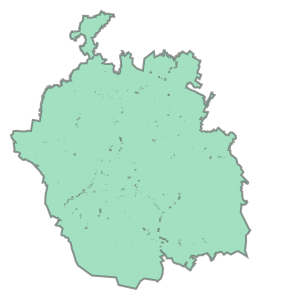

In [104]:
metropolitan_zone_polygon_unified = metropolitan_zone_polygon.geometry.union_all()

metropolitan_zone_polygon_unified

In [202]:
gdf_metropolitan_census = gdf_census_data[gdf_census_data.geometry.within(metropolitan_zone_polygon_unified)]

## Create H3 Hexagons grid for metropolitan zone grid

In [281]:
metropolitan_zone_polygon_lat_long = gdf_metropolitan_census.copy()
metropolitan_zone_polygon_lat_long.to_crs(epsg=4326, inplace=True)
metropolitan_zone_polygon_lat_long["centroid"] = metropolitan_zone_polygon_lat_long.geometry.centroid

h3_index_ha_var = 10 # -> suitable for hectare-level analysis
h3_index_km2_var = 8 # -> suitable for km2-level analysis


metropolitan_zone_polygon_lat_long["h3_ha"] = (
    metropolitan_zone_polygon_lat_long["centroid"]
    .apply(lambda p: h3.latlng_to_cell(p.y, p.x, h3_index_ha_var))
)

metropolitan_zone_polygon_lat_long["h3_km2"] = (
    metropolitan_zone_polygon_lat_long["centroid"]
    .apply(lambda p: h3.latlng_to_cell(p.y, p.x, h3_index_km2_var))
)


metropolitan_zone_polygon_km2 = (
    metropolitan_zone_polygon_lat_long[["h3_km2"]]
    .drop_duplicates()
    .reset_index(drop=True)
)



hex_km2_polygons = []
for h in metropolitan_zone_polygon_km2["h3_km2"]:
    boundary = h3.cell_to_boundary(h)
    poly = Polygon([(lng, lat) for (lat, lng) in boundary])
    hex_km2_polygons.append(poly)



h3_geom_km2 = gpd.GeoDataFrame(
    {"h3_index_km2": metropolitan_zone_polygon_km2["h3_km2"], "geometry": hex_km2_polygons},
    geometry="geometry",
    crs="EPSG:4326",
)

/var/folders/wq/fkfjjd7j01z6bc6329g87fv40000gn/T/ipykernel_61606/4197528069.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  metropolitan_zone_polygon_lat_long["centroid"] = metropolitan_zone_polygon_lat_long.geometry.centroid


In [ ]:
h3_geom_km2.to_crs(epsg=32614, inplace=True)


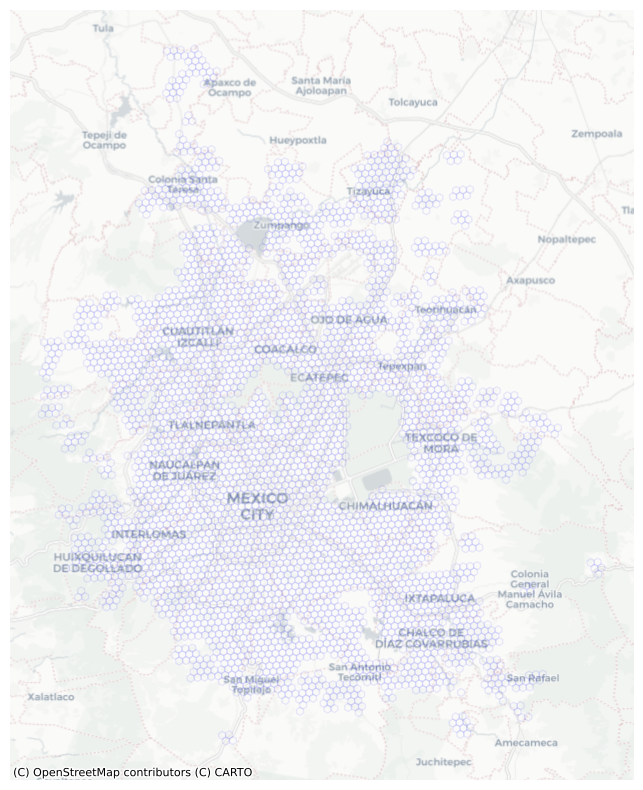

In [287]:
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
h3_geom_km2.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1, alpha=0.075)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf_metropolitan_census.crs)

## Final Result

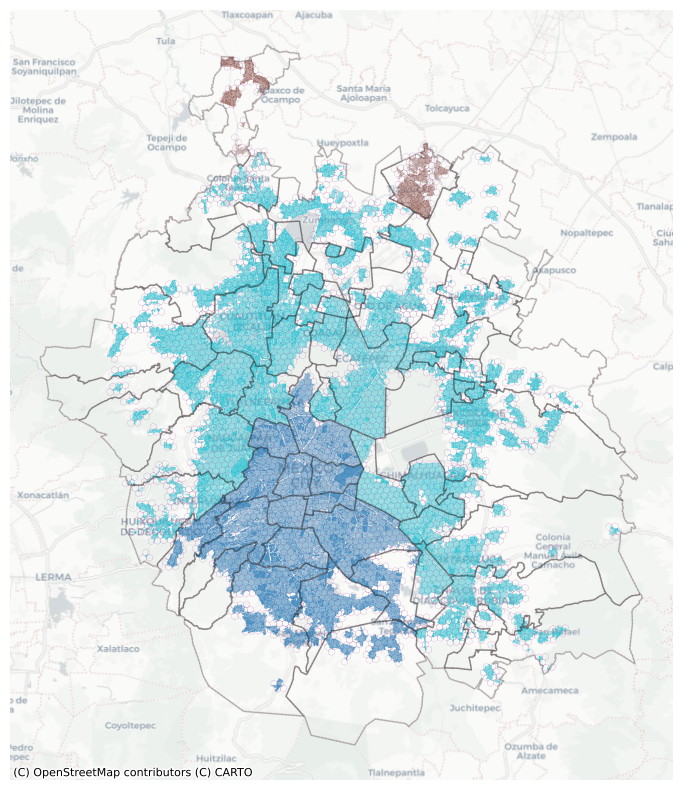

In [296]:
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')

h3_geom_km2.plot(ax=ax, facecolor='none', edgecolor='purple', linewidth=0.075, alpha=1)
metropolitan_zone_polygon.boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, alpha=0.25)
gdf_metropolitan_census.plot(ax=ax, column='NOM_ENT', alpha=0.75, edgecolor='white', linewidth=0.02)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf_metropolitan_census.crs)

In [293]:
gdf_metropolitan_census.columns

Index(['CVEGEO', 'CVE_ENT', 'NOM_ENT', 'CVE_MUN', 'NOM_MUN', 'CVE_AGEB',
       'CVE_MZA', 'AMBITO', 'POBTOT', 'POBFEM',
       ...
       'VPH_CEL', 'VPH_INTER', 'VPH_STVP', 'VPH_SPMVPI', 'VPH_CVJ',
       'VPH_SINRTV', 'VPH_SINLTC', 'VPH_SINCINT', 'VPH_SINTIC', 'geometry'],
      dtype='object', length=231)

# Add Census and complimentary data to km2 hex

In [297]:
hex_km2_census_data = h3_geom_km2.copy()
# Spatial join between hexagons and census data
hex_census_joined = gpd.sjoin(hex_km2_census_data, gdf_metropolitan_census, how='left', predicate='intersects')

# Get numeric and object columns
numeric_cols = gdf_metropolitan_census.select_dtypes(include=[np.number]).columns.tolist()
object_cols = gdf_metropolitan_census.select_dtypes(include=['object']).columns.tolist()

# Create aggregation dictionary
agg_dict = {col: 'sum' for col in numeric_cols}
agg_dict.update({col: 'first' for col in object_cols if col != 'geometry'})

# Group by h3_index_km2 and aggregate
hex_km2_census_data = (hex_census_joined.groupby('h3_index_km2')
                       .agg(agg_dict)
                       .reset_index())

hex_km2_census_data = h3_geom_km2.merge(hex_km2_census_data, on='h3_index_km2', how='left')

In [304]:
hex_km2_census_data

h3_index_km2                                           geometry  \
0     884995849bfffff  POLYGON ((475879.093 2139753.989, 476354.203 2...   
1     8849958497fffff  POLYGON ((477304.405 2140725.268, 477779.498 2...   
2     884995b143fffff  POLYGON ((474229.452 2142200.135, 474704.607 2...   
3     8849958499fffff  POLYGON ((476428.92 2138938.69, 476904.014 213...   
4     884995b16dfffff  POLYGON ((477742.154 2141618.566, 478217.246 2...   
...               ...                                                ...   
3697  88499539dbfffff  POLYGON ((506202.154 2199695.266, 506677.159 2...   
3698  8849953ab1fffff  POLYGON ((499952.238 2196630.483, 500427.333 2...   
3699  8849953a31fffff  POLYGON ((503797.283 2190912.782, 504272.273 2...   
3700  8849953a21fffff  POLYGON ((505882.623 2189356.434, 506357.565 2...   
3701  884995384bfffff  POLYGON ((505222.233 2191883.222, 505697.204 2...   

       POBTOT   POBFEM   POBMAS  P_0A2  P_0A2_F  P_0A2_M  P_3YMAS  P_3YMAS_F  \
0     16286.0   8480.0   7804.0  419.0    169.0    178.0  15786.0     8235.0   
1     13984.0   7363.0   6608.0  278.0    103.0    127.0  13660.0     7216.0   
2     13455.0   7208.0   6246.0  377.0    158.0    167.0  13037.0     7011.0   
3     20158.0  10536.0   9622.0  570.0    268.0    264.0  19551.0    10229.0   
4     28266.0  14684.0  13575.0  731.0    299.0    322.0  27433.0    14279.0   
...       ...      ...      ...    ...      ...      ...      ...        ...   
3697    151.0     74.0     77.0    7.0      3.0      4.0    137.0       68.0   
3698    301.0    142.0    159.0   10.0      3.0      0.0    285.0      134.0   
3699    299.0    151.0    137.0    9.0      6.0      3.0    278.0      144.0   
3700     84.0     32.0     27.0    3.0      0.0      0.0     55.0       29.0   
3701   1080.0    527.0    551.0   50.0     20.0     23.0   1027.0      502.0   

      ...  VPH_SINCINT  VPH_SINTIC            CVEGEO  CVE_ENT  \
0     ...        729.0         0.0  0901000012288028       09   
1     ...        475.0         6.0  0901000012292036       09   
2     ...        650.0         8.0  0901000011472053       09   
3     ...       1259.0         9.0  0901000011843022       09   
4     ...       1824.0         0.0  0901000012165020       09   
...   ...          ...         ...               ...      ...   
3697  ...          0.0         0.0  1306900020957037       13   
3698  ...         29.0         0.0  1306900550143028       13   
3699  ...         41.0         0.0  1306900080444012       13   
3700  ...          9.0         0.0  130690008043A024       13   
3701  ...        132.0         0.0  1306900080213034       13   

               NOM_ENT  CVE_MUN         NOM_MUN  CVE_AGEB  CVE_MZA  AMBITO  
0     Ciudad de México      010  Álvaro Obregón      2288      028  Urbana  
1     Ciudad de México      010  Álvaro Obregón      2292      036  Urbana  
2     Ciudad de México      010  Álvaro Obregón      1472      053  Urbana  
3     Ciudad de México      010  Álvaro Obregón      1843      022  Urbana  
4     Ciudad de México      010  Álvaro Obregón      2165      020  Urbana  
...                ...      ...             ...       ...      ...     ...  
3697           Hidalgo      069        Tizayuca      0957      037  Urbana  
3698           Hidalgo      069        Tizayuca      0143      028  Urbana  
3699           Hidalgo      069        Tizayuca      0444      012  Urbana  
3700           Hidalgo      069        Tizayuca      043A      024  Urbana  
3701           Hidalgo      069        Tizayuca      0213      034  Urbana  

[3702 rows x 232 columns]

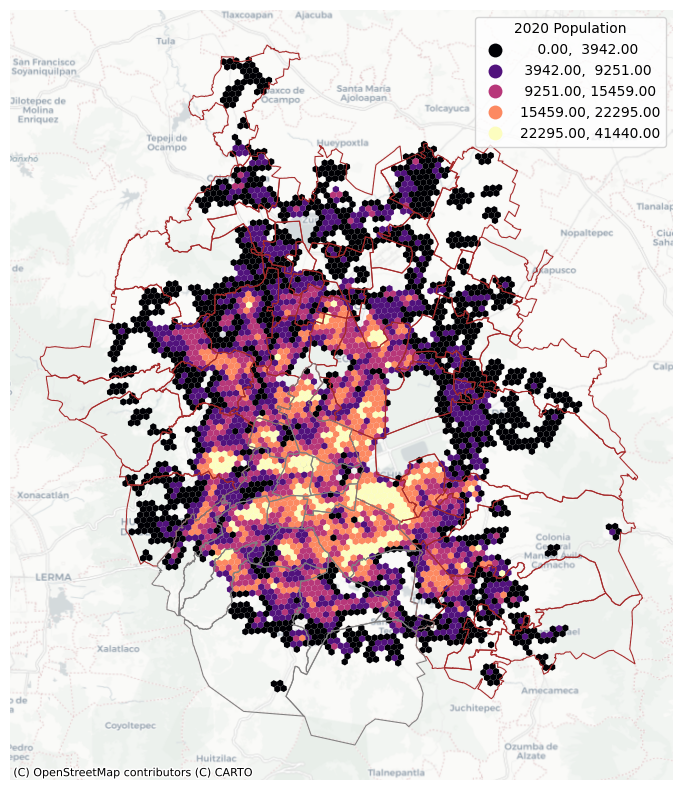

In [328]:
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')




hex_km2_census_data.plot(ax=ax, cmap='magma', column="POBTOT", linewidth=1, scheme='naturalbreaks', alpha=1, legend=True, legend_kwds={'title': '2020 Population'})
metropolitan_zone_polygon[metropolitan_zone_polygon["cve_ent"]!="09"].plot(ax=ax, facecolor='none', edgecolor='brown', linewidth=0.75)
metropolitan_zone_polygon[metropolitan_zone_polygon["cve_ent"]=="09"].plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.75)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=hex_km2_census_data.crs)

# Add Airbnb listing per hexagon

In [393]:
airbnb_listings = pd.read_csv('./data/airbnb/listings.csv')
airbnb_listings_gdf = gpd.GeoDataFrame(
    airbnb_listings,
    geometry=gpd.points_from_xy(airbnb_listings.longitude, airbnb_listings.latitude),
    crs="EPSG:4326"
)
airbnb_listings_gdf.to_crs(epsg=32614, inplace=True)

In [394]:
hex_km2_global = hex_km2_census_data.copy()
hex_km2_global = gpd.sjoin(hex_km2_global, airbnb_listings_gdf, how='left', predicate='contains')

columns_airbnb_listings_gdf = airbnb_listings_gdf.columns.tolist()
columns_airbnb_listings_gdf.remove('geometry')

# Add number of listings per hexagon
hex_km2_global['num_listings'] = hex_km2_global.groupby('h3_index_km2')['id'].transform('count')

hex_km2_global = hex_km2_global.drop(columns=columns_airbnb_listings_gdf + ['index_right'])
hex_km2_global.rename(columns={'geometry_x': 'geometry'}, inplace=True)
hex_km2_global = hex_km2_global.drop_duplicates(subset=['h3_index_km2']).reset_index(drop=True)


# Add Economic Activity per hexagon

In [395]:
def extract_denue_data(zip_path, target_directory):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('./data/temp_extract')

    os.makedirs(target_directory, exist_ok=True)

    source_dir = './data/temp_extract/conjunto_de_datos/'
    for filename in os.listdir(source_dir):
        source_file = os.path.join(source_dir, filename)
        target_file = os.path.join(target_directory, filename)
        os.rename(source_file, target_file)

    shutil.rmtree('./data/temp_extract')

In [396]:
extract_denue_data('./data/denue/cdmx_shp.zip', './data/denue/cdmx/')
cdmx_denue = gpd.read_file('./data/denue/cdmx/denue_inegi_09_.shp')

extract_denue_data('./data/denue/hidalgo_shp.zip', './data/denue/hidalgo/')   
hidalgo_denue = gpd.read_file('./data/denue/hidalgo/denue_inegi_13_.shp')

extract_denue_data('./data/denue/edomex_1_shp.zip', './data/denue/edomex_1/')
extract_denue_data('./data/denue/edomex_2_shp.zip', './data/denue/edomex_2/')

edomex_denue_1 = gpd.read_file('./data/denue/edomex_1/denue_inegi_15_1.shp')
edomex_denue_2 = gpd.read_file('./data/denue/edomex_2/denue_inegi_15_2.shp')

edomex_denue = gpd.GeoDataFrame(pd.concat([edomex_denue_1, edomex_denue_2], ignore_index=True), crs=edomex_denue_1.crs)
del edomex_denue_1
del edomex_denue_2

single_denue = gpd.GeoDataFrame(pd.concat([cdmx_denue, hidalgo_denue, edomex_denue], ignore_index=True), crs=cdmx_denue.crs)

single_denue = single_denue[['id', 'clee', 'nom_estab', 'raz_social', 'codigo_act', 'nombre_act',
       'per_ocu', 'tipo_vial', 'nom_vial', 'tipo_v_e_1', 'nom_v_e_1',
       'tipo_v_e_2', 'nom_v_e_2', 'tipo_v_e_3', 'nom_v_e_3', 'numero_ext',
       'letra_ext', 'edificio', 'edificio_e', 'numero_int', 'letra_int',
       'tipo_asent', 'nomb_asent', 'tipoCenCom', 'nom_CenCom', 'num_local',
       'cod_postal', 'cve_ent', 'entidad', 'cve_mun', 'municipio', 'cve_loc',
       'localidad', 'ageb', 'manzana', 'telefono', 'correoelec', 'www',
       'tipoUniEco', 'fecha_alta', 'geometry']]

In [397]:
single_denue.to_crs(epsg=32614, inplace=True)

In [398]:
metropolitan_cdmx_denue = single_denue.clip(hex_km2_global)
#del single_denue
#del cdmx_denue
#del hidalgo_denue
#del edomex_denue

In [399]:
metropolitan_cdmx_denue = metropolitan_cdmx_denue[['id', 'clee', 'codigo_act', 'per_ocu', 'cve_ent', 'entidad', 'cve_mun', 'municipio', 'fecha_alta', 'geometry']]

In [410]:
econocic_corridors = metropolitan_cdmx_denue.copy()

economic_corridors_activity_codes_list = [ 
    # Wholesale, retail
    '43', 
    '46',
    # Professional services, management, admin
    '51', # Media
    '52', # Finance and insurance
    '53', # Real estate and rental
    '54', # Professional, scientific, and technical services
    '55', # Management of companies and enterprises
    '56',
    # Education & health services
     '61', # Educational services
     '62', # Health care and social assistance
    # Government
    '93', # Public administration
    # Industrial/logistics
    # '31', # Utilities
    # '32', # Construction
    # '33', # Manufacturing
    # '48', # Transportation and warehousing
    # '49', # Transportation and warehousing
    # Tourism / accommodation
    '72', # Accommodation and food services
    # Entertainment and recreation
    '71',
]

In [401]:
econocic_corridors["clave_actividad_economica"] = econocic_corridors["codigo_act"].str[:2]
econocic_corridors[["codigo_act", "clave_actividad_economica"]]

codigo_act clave_actividad_economica
158788     461110                        46
211305     461110                        46
54432      461110                        46
434322     813210                        81
210944     461110                        46
...           ...                       ...
494044     461110                        46
533051     461110                        46
491606     461110                        46
585213     722518                        72
513296     462112                        46

[1053716 rows x 2 columns]

In [402]:
econocic_corridors = econocic_corridors[econocic_corridors['clave_actividad_economica'].isin(economic_corridors_activity_codes_list)]

# Add economic corridor per hexagon

In [403]:
econocic_corridors.to_crs(epsg=32614, inplace=True)

# Start from your census hex grid
#hex_km2_global.drop(columns=['num_listings'], inplace=True)

# Spatial join between hexagons and economic corridors
hex_economic_joined = gpd.sjoin(
    hex_km2_global,
    econocic_corridors,
    how='left',
    predicate='intersects'
)

columns_economic_corridors = econocic_corridors.columns.tolist()
columns_economic_corridors.remove('geometry')

# 1. Count corridors per hex
corridor_counts = (
    hex_economic_joined
    .dropna(subset=['id'])  # hexes with no corridor will drop here
    .groupby('h3_index_km2')['id']
    .size()                 # counts rows per hex
    .rename('num_economic_corridors')
    .reset_index()
)

# 2. Merge counts back into the hex grid
hex_km2_global = hex_km2_global.merge(
    corridor_counts,
    on='h3_index_km2',
    how='left'
)

# Hexes with no corridors → 0
hex_km2_global['num_economic_corridors'] = (
    hex_km2_global['num_economic_corridors']
    .fillna(0)
    .astype(int)
)

# 3. Clean up extra columns from the spatial join if needed (just in case)
cols_to_drop = [c for c in columns_economic_corridors + ['index_right'] 
                if c in hex_km2_global.columns]
hex_km2_global = hex_km2_global.drop(columns=cols_to_drop)

# If you *know* each h3_index_km2 is unique in hex_km2_global, no need for drop_duplicates
# But if you want to be safe:
hex_km2_global = hex_km2_global.drop_duplicates(subset=['h3_index_km2']).reset_index(drop=True)

# Population vs Economic Activity vs Airbnb

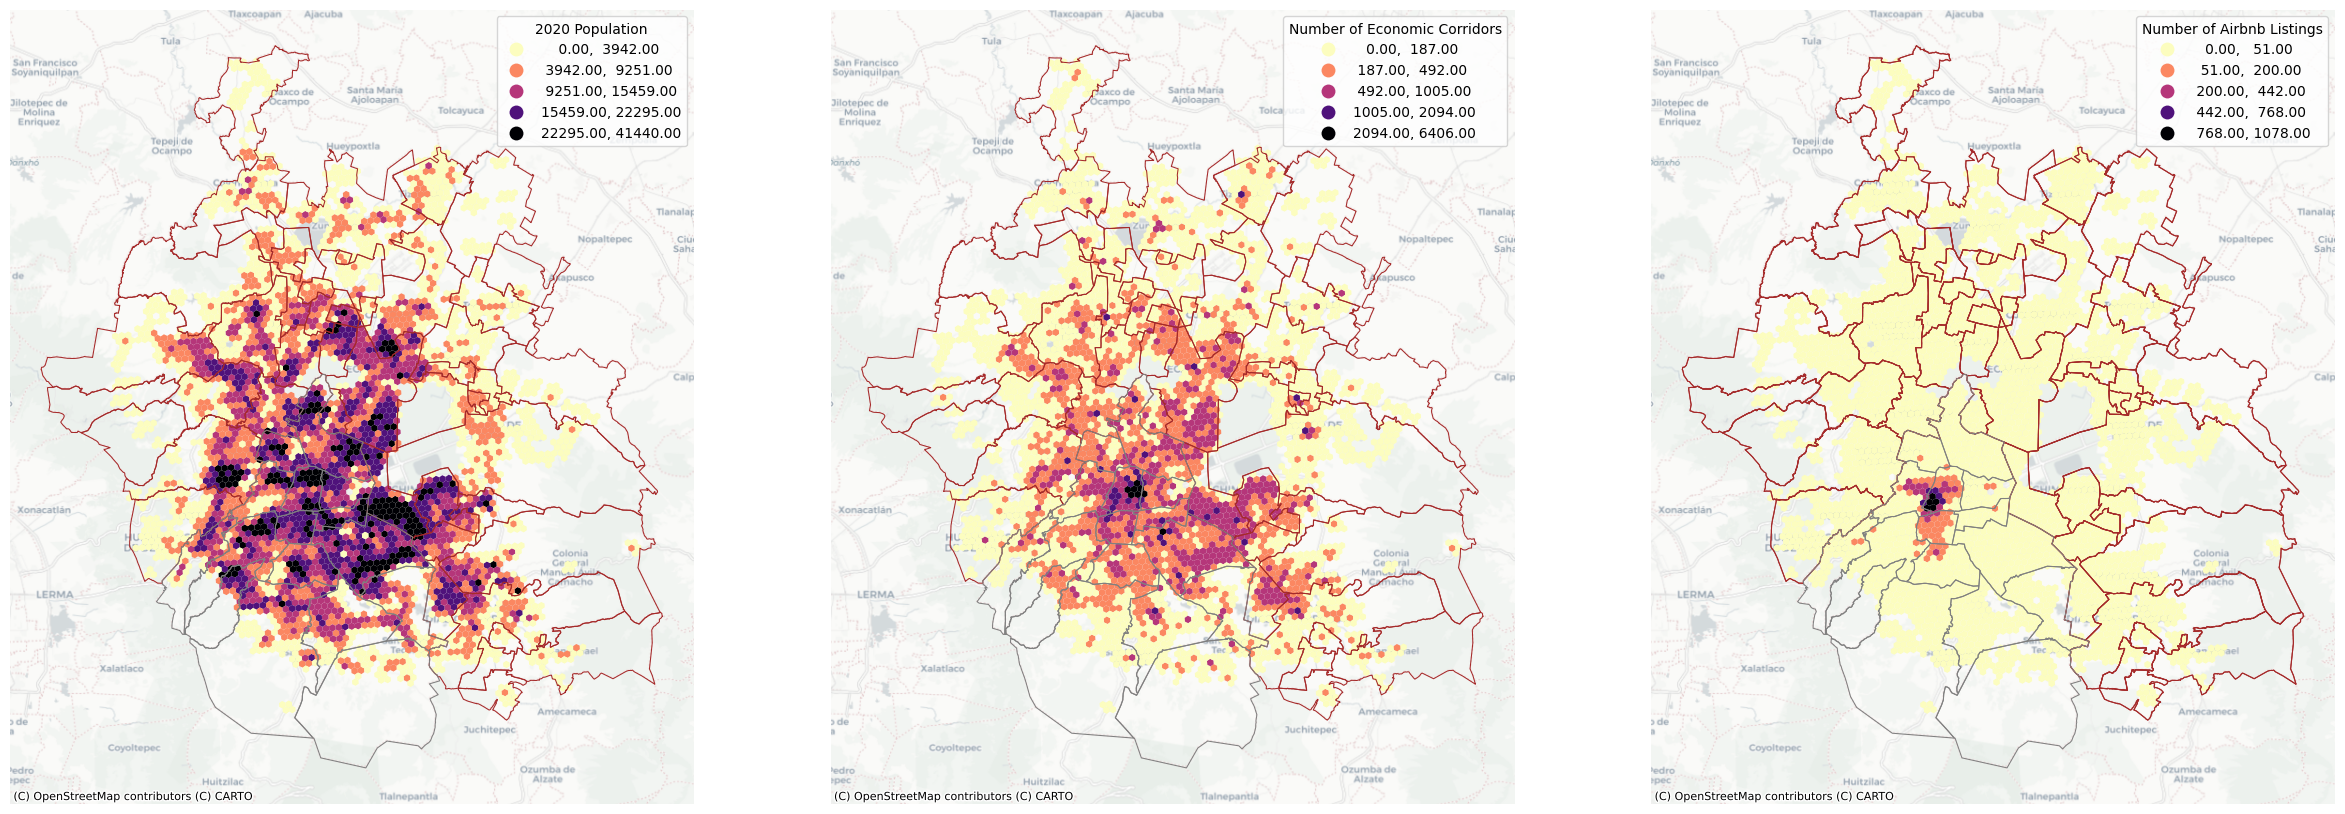

In [409]:
fig, ax = plt.subplots(1,3,figsize=(30,30))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

hex_km2_global.plot(ax=ax[0], cmap='magma_r', column="POBTOT", linewidth=1, scheme='naturalbreaks', alpha=1, legend=True, legend_kwds={'title': '2020 Population'})
metropolitan_zone_polygon[metropolitan_zone_polygon["cve_ent"]!="09"].plot(ax=ax[0], facecolor='none', edgecolor='brown', linewidth=0.75)
metropolitan_zone_polygon[metropolitan_zone_polygon["cve_ent"]=="09"].plot(ax=ax[0], facecolor='none', edgecolor='gray', linewidth=0.75)
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Positron, crs=hex_km2_census_data.crs)

hex_km2_global.plot(ax=ax[1], column='num_economic_corridors', cmap='magma_r', legend=True, scheme='naturalbreaks', alpha=1, legend_kwds={'title': 'Number of Economic Corridors'})
metropolitan_zone_polygon[metropolitan_zone_polygon["cve_ent"]!="09"].plot(ax=ax[1], facecolor='none', edgecolor='brown', linewidth=0.75)
metropolitan_zone_polygon[metropolitan_zone_polygon["cve_ent"]=="09"].plot(ax=ax[1], facecolor='none', edgecolor='gray', linewidth=0.75)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Positron, crs=hex_km2_global.crs)

hex_km2_global.plot(ax=ax[2], column='num_listings', cmap='magma_r', legend=True, scheme='naturalbreaks', alpha=1, legend_kwds={'title': 'Number of Airbnb Listings'})
metropolitan_zone_polygon[metropolitan_zone_polygon["cve_ent"]!="09"].plot(ax=ax[2], facecolor='none', edgecolor='brown', linewidth=0.75)
metropolitan_zone_polygon[metropolitan_zone_polygon["cve_ent"]!="09"].plot(ax=ax[2], facecolor='none', edgecolor='brown', linewidth=0.75)
metropolitan_zone_polygon[metropolitan_zone_polygon["cve_ent"]=="09"].plot(ax=ax[2], facecolor='none', edgecolor='gray', linewidth=0.75)
ctx.add_basemap(ax[2], source=ctx.providers.CartoDB.Positron, crs=hex_km2_global.crs)

# Accesibility 

## Network Stablishment

In [420]:
walk_time = 20  # max walking horizon in minutes
walk_speed = 4.5  # km per hour

In [421]:
econocic_corridors_h3_copy = hex_km2_global.copy()
econocic_corridors_h3_copy.to_crs(epsg=4326, inplace=True)

In [414]:
metropolitan_cdmx_copy_4326 = metropolitan_zone_polygon.copy()
metropolitan_cdmx_copy_4326.to_crs(epsg=4326, inplace=True)
single_polygon = metropolitan_cdmx_copy_4326.copy()
single_polygon = single_polygon.geometry.union_all()

In [416]:
G_Walk = ox.graph_from_polygon(single_polygon, network_type='walk', simplify=True)

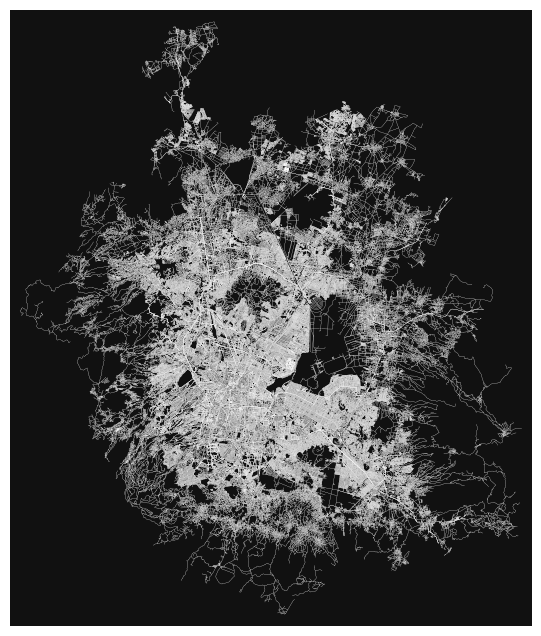

In [417]:
fig, ax = ox.plot.plot_graph(G_Walk, node_size=0, edge_color="w", edge_linewidth=0.1)

In [422]:
for _, _, data in G_Walk.edges(data=True):
    data["speed_kph"] = walk_speed
G_walk = ox.routing.add_edge_travel_times(G_Walk)

In [486]:
nodes = ox.convert.graph_to_gdfs(G_walk, edges=False)[["x", "y"]]
edges = ox.convert.graph_to_gdfs(G_walk, nodes=False).reset_index()[["u", "v", "travel_time"]]

In [494]:
tags = {
   
    # --- Public transport ---
    
    "public_transport": [
        "stop_position", 
    ],

  
}
bbox = nodes["x"].min(), nodes["y"].min(), nodes["x"].max(), nodes["y"].max()
amenities = ox.features.features_from_bbox(bbox, tags=tags)
amenities.shape

(563, 50)

In [495]:
import pandana

In [496]:
# construct the pandana network model
network = pandana.Network(
    node_x=nodes["x"],
    node_y=nodes["y"],
    edge_from=edges["u"],
    edge_to=edges["v"],
    edge_weights=edges[["travel_time"]],
)

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 550238
Setting CH edge vector of size 1490538
Range graph removed 1505626 edges of 2981076
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [497]:
centroids = amenities.centroid

/var/folders/wq/fkfjjd7j01z6bc6329g87fv40000gn/T/ipykernel_61606/1232309418.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = amenities.centroid


In [498]:
maxdist = walk_time * 60  # minutes -> seconds, to match travel_time units
network.set_pois(
    category="stop_area", maxdist=maxdist, maxitems=5, x_col=centroids.x, y_col=centroids.y
)

In [499]:
# calculate travel time to nearest amenity from each node in network
distances = network.nearest_pois(distance=maxdist, category="stop_area", num_pois=5, )
distances.astype(int).head()

1     2     3     4     5
osmid                                  
268803401  1200  1200  1200  1200  1200
268803404  1200  1200  1200  1200  1200
268803406  1200  1200  1200  1200  1200
268803413   982  1107  1200  1200  1200
268803497   947  1019  1200  1200  1200

In [500]:
node_ids = network.get_node_ids(centroids.x, centroids.y)
network.set(node_ids, name="stop_area")

# aggregate the variable to all the nodes in the network
# when counting, the decay doesn't matter (but would for summing)
access = network.aggregate(distance=maxdist, type="count", decay="linear", name="stop_area")

# let's cap it at 5, assuming no further utility from a larger choice set
access = access.clip(upper=20)
access.describe()

count    550238.000000
mean          1.044274
std           3.027377
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
dtype: float64

In [501]:
nodes = ox.convert.graph_to_gdfs(G_walk, edges=False)[["x", "y"]]
nodes = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes.x, nodes.y), crs="EPSG:4326")
nodes.to_crs(epsg=32614, inplace=True)

In [502]:
nodes["x"] = nodes.geometry.x
nodes["y"] = nodes.geometry.y

In [503]:
access = access.reset_index().rename(columns={"index": "node_id", "stop_area": "accessibility_stop_areas"})

In [504]:
access.rename(columns={0: "stops_within_walk_time"}, inplace=True)

In [505]:
access.columns

Index(['osmid', 'stops_within_walk_time'], dtype='object')

# Final Maps

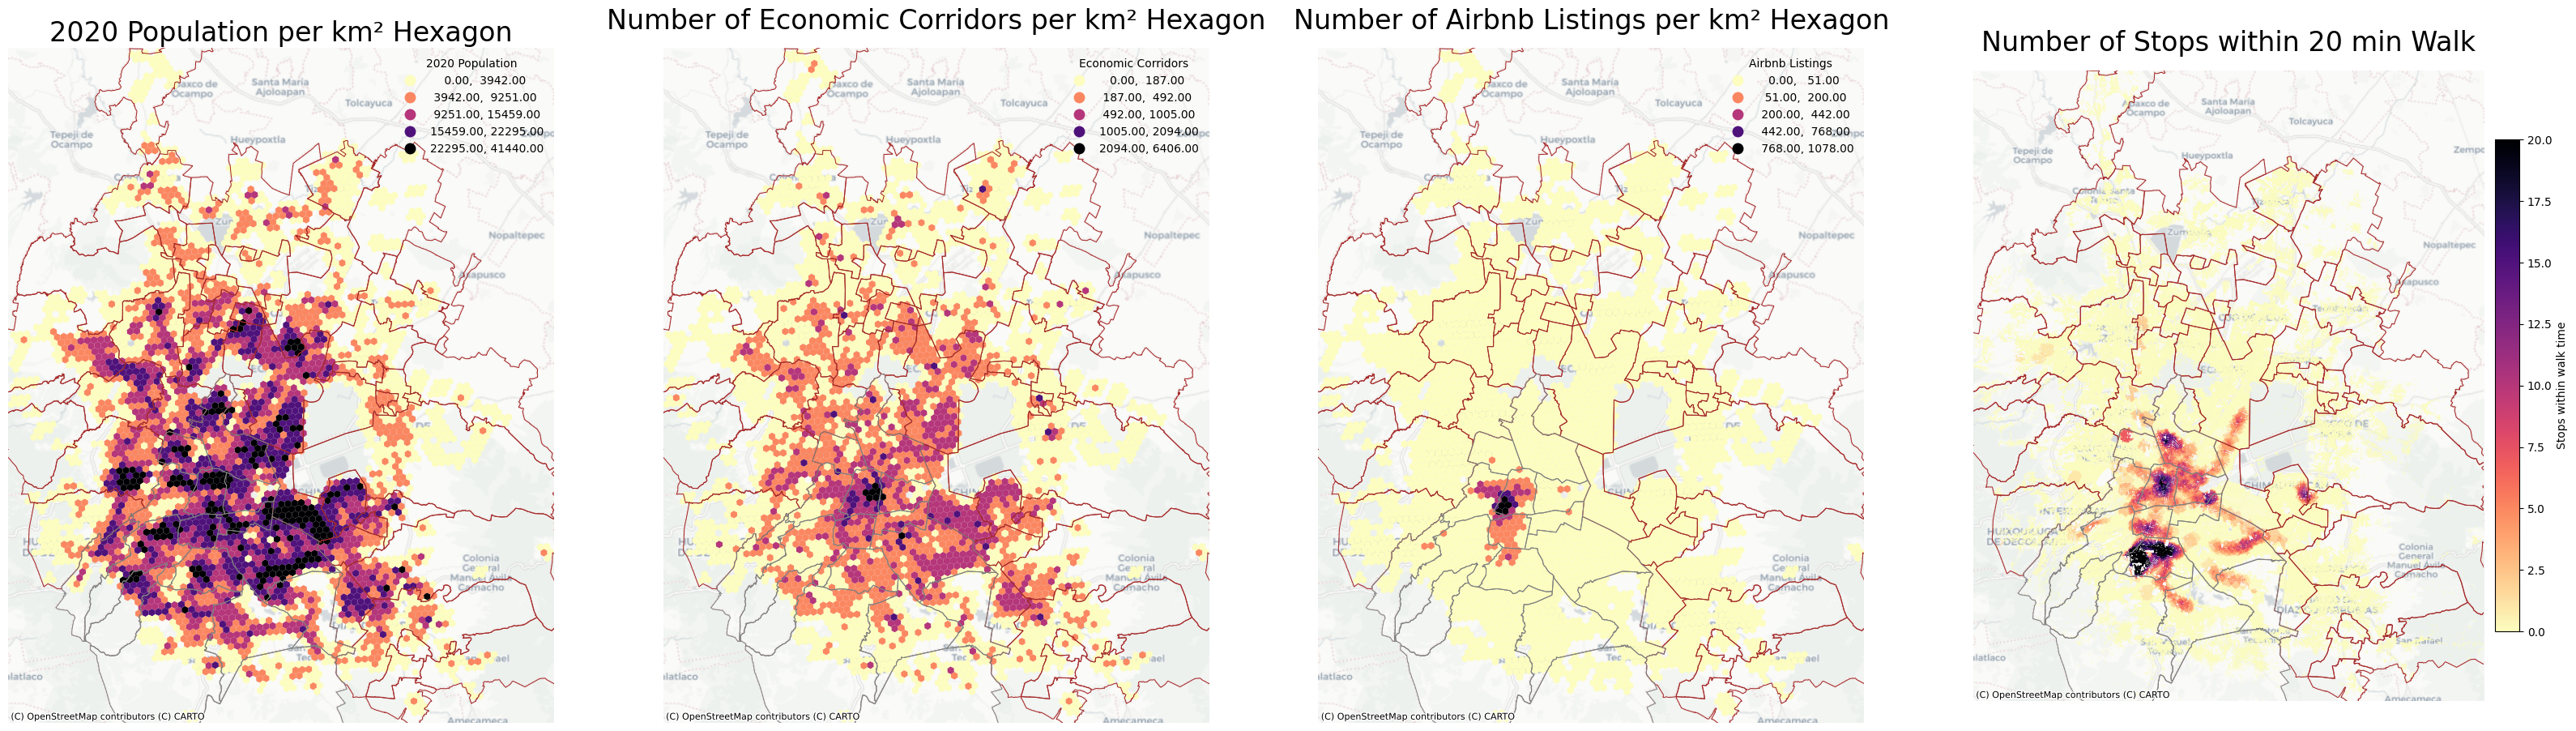

In [506]:
import matplotlib.pyplot as plt
import contextily as ctx

xmin, ymin, xmax, ymax = hex_km2_global.total_bounds

fig, ax = plt.subplots(
    1, 4,
    figsize=(40, 40)
)

for a in ax:
    a.set_axis_off()
    a.set_xlim(xmin, xmax)
    a.set_ylim(ymin, ymax)

ax[0].set_title("2020 Population per km² Hexagon", fontsize=24)
ax[1].set_title("Number of Economic Corridors per km² Hexagon", fontsize=24)
ax[2].set_title("Number of Airbnb Listings per km² Hexagon", fontsize=24)
ax[3].set_title(f"Number of Stops within {walk_time} min Walk", fontsize=24)

hex_km2_global.plot(
    ax=ax[0], cmap="magma_r", column="POBTOT",
    linewidth=0, alpha=1,
    scheme="naturalbreaks",
    legend=True,
    legend_kwds={"title": "2020 Population", "loc": "upper right", "frameon": False}
)
metropolitan_zone_polygon[metropolitan_zone_polygon["cve_ent"]!="09"].plot(
    ax=ax[0], facecolor="none", edgecolor="brown", linewidth=0.75
)
metropolitan_zone_polygon[metropolitan_zone_polygon["cve_ent"]=="09"].plot(
    ax=ax[0], facecolor="none", edgecolor="gray", linewidth=0.75
)
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Positron, crs=hex_km2_global.crs)


hex_km2_global.plot(
    ax=ax[1], cmap="magma_r", column="num_economic_corridors",
    linewidth=0, alpha=1,
    scheme="naturalbreaks",
    legend=True,
    legend_kwds={"title": "Economic Corridors", "loc": "upper right", "frameon": False}
)
metropolitan_zone_polygon[metropolitan_zone_polygon["cve_ent"]!="09"].plot(
    ax=ax[1], facecolor="none", edgecolor="brown", linewidth=0.75
)
metropolitan_zone_polygon[metropolitan_zone_polygon["cve_ent"]=="09"].plot(
    ax=ax[1], facecolor="none", edgecolor="gray", linewidth=0.75
)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Positron, crs=hex_km2_global.crs)


hex_km2_global.plot(
    ax=ax[2], cmap="magma_r", column="num_listings",
    linewidth=0, alpha=1,
    scheme="naturalbreaks",
    legend=True,
    legend_kwds={"title": "Airbnb Listings", "loc": "upper right", "frameon": False}
)

metropolitan_zone_polygon[metropolitan_zone_polygon["cve_ent"]!="09"].plot(
    ax=ax[2], facecolor="none", edgecolor="brown", linewidth=0.75
)
metropolitan_zone_polygon[metropolitan_zone_polygon["cve_ent"]=="09"].plot(
    ax=ax[2], facecolor="none", edgecolor="gray", linewidth=0.75
)
ctx.add_basemap(ax[2], source=ctx.providers.CartoDB.Positron, crs=hex_km2_global.crs)


sc1 = ax[3].scatter(
    x=nodes["x"], y=nodes["y"],
    c=access["stops_within_walk_time"],
    cmap="magma_r", s=0.5, linewidths=0
)

metropolitan_zone_polygon[metropolitan_zone_polygon["cve_ent"]!="09"].plot(
    ax=ax[3], facecolor="none", edgecolor="brown", linewidth=0.75
)
metropolitan_zone_polygon[metropolitan_zone_polygon["cve_ent"]=="09"].plot(
    ax=ax[3], facecolor="none", edgecolor="gray", linewidth=0.75
)
ctx.add_basemap(ax[3], source=ctx.providers.CartoDB.Positron, crs=hex_km2_global.crs)

# Key fix: axis-attached colorbar with small footprint (no huge right margin)
cbar = fig.colorbar(sc1, ax=ax[3], fraction=0.045, pad=0.02)
cbar.set_label("Stops within walk time")

plt.show()